In [1]:
import re
import os
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from scipy import stats
import matplotlib.pyplot as plt
import scienceplots
style_path = os.path.join(os.path.dirname(scienceplots.__file__), 'styles')
plt.style.core.USER_LIBRARY_PATHS.append(style_path)
plt.style.reload_library()
plt.style.use("science")
from matplotlib import ticker
import tol_colors as tc
cset = tc.colorsets["medium_contrast"]

In [2]:
RES_DIR = "./result/timegapplot"

## Load Datta

In [4]:
def readLog(file_path):
    """
    Try different encodings to read the file
    """
    encodings = ["utf-8", "gb18030", "latin1"]
    for enc in encodings:
        try:
            with open(file_path, "r", encoding=enc) as f:
                return f.read()
        except UnicodeDecodeError:
            continue
    raise ValueError("Unable to detect file encoding")

In [5]:
log_content = readLog(os.path.join(RES_DIR+"/100/gurobi/0_20_cls_100_no_time.log"))
print(log_content[:103])

nohup: ignoring input
/home/jingyizhao/lanyue/L2O/L2O-pMINLP-master/L2O-pMINLP-master
Integer Quadratic


In [6]:
def extractRawTables(log_content):
    """
    Extract table sections from the log file content.
    """
    header_pattern = r"""
        Nodes\s+\|\s+Current\s+Node\s+\|\s+Objective\s+Bounds\s+\|\s+Work\s+
        Expl\s+Unexpl\s+\|\s+Obj\s+Depth\s+IntInf\s+\|\s+Incumbent\s+BestBd\s+Gap\s+\|\s+It/Node\s+Time
    """
    end_pattern = r"Explored"
    start_pattern = re.compile(header_pattern.strip(), re.VERBOSE | re.MULTILINE)
    end_pattern = re.compile(end_pattern.strip(), re.VERBOSE | re.MULTILINE)
    start_matches = list(start_pattern.finditer(log_content))
    end_matches = list(end_pattern.finditer(log_content))
    tables = []
    for i in range(len(start_matches)):
        start = start_matches[i].end()
        end = end_matches[i].start() if i < len(end_matches) else len(log_content)
        table_content = log_content[start:end].strip()
        tables.append(table_content)
    return tables

In [7]:
raw_tables = extractRawTables(log_content)

In [8]:
def aggregateTables(tables):
    """
    Given a list of raw table strings, parse and process them into a unified
    time-aligned DataFrame with gap percentiles (q25, q50, q75).
    """
    processed_dfs = []
    for idx, table in enumerate(tables):
        df_raw = parseTable(table)
        if df_raw.empty:
            print(f"Table {idx+1} skipped (no data)")
            continue
        df_interp = processTime(df_raw)
        if not df_interp.empty:
            processed_dfs.append(df_interp)
    if not processed_dfs:
        print("No valid tables processed.")
        return pd.DataFrame()
    combined_df = pd.concat(processed_dfs, ignore_index=True)
    aggregated = combined_df.groupby('time')['gap'].agg(
        q25=lambda x: np.percentile(x, 25),
        q50=lambda x: np.percentile(x, 50),
        q75=lambda x: np.percentile(x, 75)
    ).reset_index()
    return aggregated


def parseTable(table_str):
    """
    Convert a raw optimization log table string into a pandas DataFrame.
    """
    data = []
    lines = [
        ln.strip() for ln in table_str.split('\n')
        if ln.strip() and not ln.startswith(('+-', '|--'))
    ]
    for line in lines:
        cols = re.split(r'\s+', line)
        if len(cols) < 4:
            continue
        try:
            time_str = cols[-1].replace('s', '').strip()
            time = float(time_str) if '.' in time_str else int(time_str)
            gap_str = cols[-3]
            if gap_str == "-":
                gap = 10000.0  # use a placeholder for missing gaps
            else:
                gap = float(gap_str.strip('%')) / 100.0

            data.append([time, gap])
        except Exception as e:
            print(f"Skipping malformed line: {line}\nReason: {e}")
            continue
    return pd.DataFrame(data, columns=["time", "gap"])


def processTime(raw_df):
    """
    Process time-gap data: interpolation and align to full time range.
    """
    try:
        raw_df = raw_df.groupby('time')['gap'].mean().reset_index()
        full_time = np.arange(0, 10801)
        interp_gap = np.interp(full_time, raw_df['time'], raw_df['gap'])
        return pd.DataFrame({'time': full_time, 'gap': interp_gap})
    except Exception as e:
        print(f"Data processing error: {str(e)}")
        return pd.DataFrame()

In [9]:
aggregateTables(raw_tables)

,time,q25,q50,q75
0,0,10000.0000,10000.0000,10000.0000
1,1,9000.1000,10000.0000,10000.0000
2,2,8000.2000,10000.0000,10000.0000
3,3,7000.3000,10000.0000,10000.0000
4,4,6000.4000,10000.0000,10000.0000
...,...,...,...,...
10796,10796,0.0538,0.0558,0.0565
10797,10797,0.0538,0.0558,0.0565
10798,10798,0.0538,0.0558,0.0565
10799,10799,0.0538,0.0558,0.0565


## Plot

In [26]:
def plotGapLogs(log_paths, title, ylim):
    """
    Plot optimality gap curves from multiple Gurobi .log files.
    """
    # set plot
    colors = [cset.light_yellow, cset.dark_blue, cset.dark_red]
    labels = ["No Warm-Starting", "Start from RC-P", "Start from LT-P"]
    plt.figure(figsize=(10, 6))
    # read log
    for i, log_path in enumerate(log_paths):
        log_path = os.path.join(RES_DIR+log_path)
        if not os.path.exists(log_path):
            print(f"[Warning] File not found: {log_path}")
            continue
        print(f"[Info] Processing: {log_path}")
        try:
            log_content = readLog(log_path)
            tables = extractRawTables(log_content)[:5]
            aggregated = aggregateTables(tables)
            if aggregated.empty:
                print(f"[Warning] No valid data in {log_path}")
                continue
            # restore nan values (over 1000%)
            aggregated[['q25', 'q50', 'q75']] = aggregated[['q25', 'q50', 'q75']].mask(aggregated[['q25', 'q50', 'q75']] > 1000)
            # get colar and label
            color = colors[i]
            label = labels[i]
            # range from 25% - 75%
            plt.fill_between(
                aggregated['time'],
                aggregated['q25'] * 100,
                aggregated['q75'] * 100,
                color=color,
                alpha=0.3
            )
            # line for medium
            plt.plot(
                aggregated['time'],
                aggregated['q50'] * 100,
                label=label,
                color=color,
                lw=4
            )
        except Exception as e:
            print(f"[Error] Failed to process {log_path}: {e}")
    # draw plot
    plt.title(title, fontsize=36)
    plt.xlabel("Time (seconds)", fontsize=32)
    plt.ylabel("Optimality Gap (\%)", fontsize=32)
    plt.grid(True, linestyle=':')
    plt.legend(fontsize=24)
    plt.xlim(0, 10800)
    plt.ylim(ylim)
    plt.tick_params(labelsize=24)
    plt.tight_layout()
    plt.savefig("gap_comparison.png", dpi=300, bbox_inches='tight')
    print("[Success] Plot saved as gap_comparison.png")
    return plt

[Info] Processing: ./result/timegapplot/100/gurobi/0_20_cls_100_no_time.log
[Info] Processing: ./result/timegapplot/100/gurobi/1_20_cls_100_initial_time.log
[Info] Processing: ./result/timegapplot/100/gurobi/2_20_thd_100_initial_time.log
[Success] Plot saved as gap_comparison.png


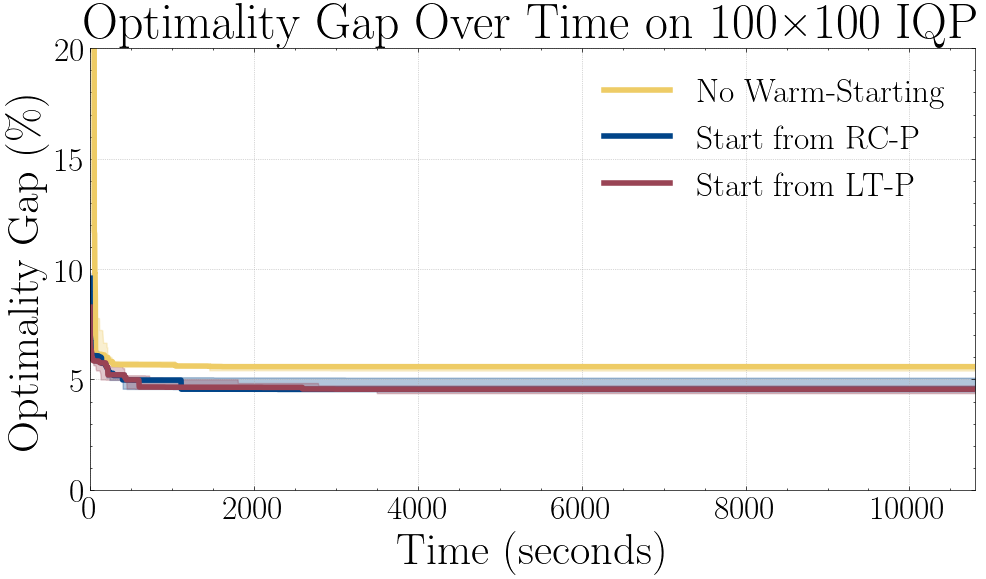

In [28]:
log_paths = ["/100/gurobi/0_20_cls_100_no_time.log",
             "/100/gurobi/1_20_cls_100_initial_time.log",
             "/100/gurobi/2_20_thd_100_initial_time.log"]
plt = plotGapLogs(log_paths, title="Optimality Gap Over Time on 100×100 IQP", ylim=(0,20))
plt.savefig("./img/gap_cq100.png", dpi=300)

[Info] Processing: ./result/timegapplot/200/gurobi/0_20_cls_200_no_time_1.log
[Info] Processing: ./result/timegapplot/200/gurobi/1_20_cls_200_initial_time_1.log
[Info] Processing: ./result/timegapplot/200/gurobi/2_20_thd_200_initial_time.log
[Success] Plot saved as gap_comparison.png


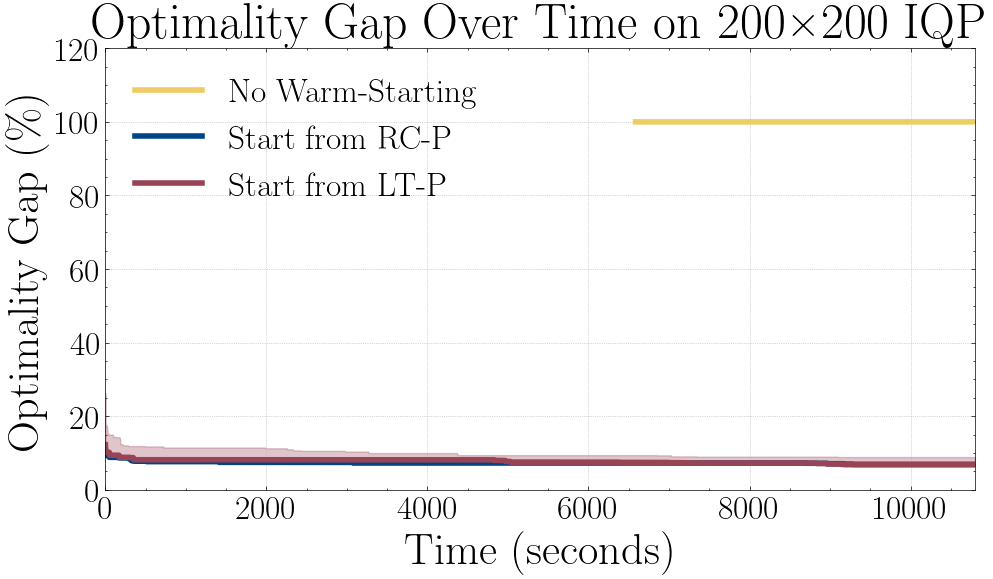

In [29]:
log_paths = ["/200/gurobi/0_20_cls_200_no_time_1.log",
             "/200/gurobi/1_20_cls_200_initial_time_1.log",
             "/200/gurobi/2_20_thd_200_initial_time.log"]
plt = plotGapLogs(log_paths, title="Optimality Gap Over Time on 200×200 IQP", ylim=(0,120))
plt.savefig("./img/gap_cq200.png", dpi=300)